# Import

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SimpleRNN, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Pour le prétraitement des textes
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import  stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from transformers import BertTokenizer, TFBertModel

# Pour la séparation des données en ensembles d'entraînement et de test
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score

import h5py


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dabereabasse/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dabereabasse/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data Collection

In [3]:
train_data = pd.read_csv('data/train.csv', index_col='id')
print('Train data shape:', train_data.shape)
train_data.head()

Train data shape: (31962, 2)


,label,tweet
id,,
1,0,@user when a father is dysfunctional and is s...
2,0,@user @user thanks for #lyft credit i can't us...
3,0,bihday your majesty
4,0,#model i love u take with u all the time in ...
5,0,factsguide: society now #motivation


In [4]:
sentences = train_data['tweet'].values
labels = train_data['label'].values

# Preprocessing

- Lowercasing
- Removal of URLs
- Removal of HTML Tags
- Removing Punctuation & Special Characters
- Stop-Words Removal
- Stemming or Lemmatization:<br>

Stemming is preferred when the meaning of the word is not important for analysis. for example: Spam Detection <br>
Lemmatization would be recommended when the meaning of the word is important for analysis. for example: Question Answer<br>

Porter stemming algorithm is one of the most common stemming algorithms<br>
which is basically designed to remove and replace well-known suffixes of English words.<br>

WordNet is a word association database for English and a useful resource for English lemmatization

- Tokenization<br>

There are different methods and libraries available to perform tokenization.<br>
NLTK, Gensim and Keras are some of the libraries that can be used to accomplish the task.<br>

In [5]:
def preprocess_text(text):
    text = text.lower() # Lowercasing
    url_pattern = r'https?://\S+|www\.\S+'
    text = re.sub(url_pattern, '', text) # Remove URLs
    html_pattern = r'<.*?>'
    text = re.sub(html_pattern, '', text) # Remove HTML tags
    punctuation_pattern = r'[^\w\s]'
    text = re.sub(punctuation_pattern, '', text) # Remove punctuation
    number_pattern = r'[0-9]'
    text = re.sub(number_pattern, '', text) # Remove numbers
    stop_words = set(stopwords.words('english'))
    word_tokens = text.split()
    text = ' '.join([word for word in word_tokens if word not in stop_words]) # Remove stopwords
    lemmatizer = WordNetLemmatizer()
    word_tokens = text.split()
    text = ' '.join([lemmatizer.lemmatize(word) for word in word_tokens]) # Lemmatization
    return text

In [6]:
# example
idx = 10
print('original text:\n', sentences[idx])
print('preprocessed text:\n', preprocess_text(sentences[idx]))

original text:
  â #ireland consumer price index (mom) climbed from previous 0.2% to 0.5% in may   #blog #silver #gold #forex
preprocessed text:
 â ireland consumer price index mom climbed previous may blog silver gold forex


In [7]:
preprocess_sentences = [preprocess_text(sentence) for sentence in sentences]

### BERT Embeddings:

* Pre-trained BERT Model: Start by choosing a pre-trained BERT model. You can use models from libraries like Hugging Face's Transformers, which provide a variety of pre-trained BERT models.

* Tokenization: BERT requires its own specific tokenization. This means splitting the text into tokens (words or subwords) and converting these tokens into IDs that correspond to BERT’s vocabulary.

* Embedding Extraction: For each tweet, feed the tokenized input into BERT to get the embedding vectors. BERT produces a vector for each token. For sequence-based tasks, you might want to use the embedding of the [CLS] token (a special token at the beginning of each sequence), or you might average or concatenate the embeddings of all tokens.

In [8]:
# Initialize tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [9]:
# Function to divide data into mini-batches
def batchify(data, batch_size):
    return [data[i:i + batch_size] for i in range(0, len(data), batch_size)]

# Function to process all sentences in mini-batches
def get_bert_embeddings(sentences, batch_size):
    embeddings = []
    max_length = max([len(bert_tokenizer.tokenize(sentence)) for sentence in sentences])
    count = 0
    for batch in batchify(sentences, batch_size):
        count += len(batch)
        print('{}/{}'.format(count, len(sentences)))
        # Tokenize and pad batch
        inputs = bert_tokenizer(batch, padding='max_length', truncation=True, max_length=max_length, return_tensors='tf')
        
        # Get embeddings
        outputs = bert_model(inputs)
        batch_embeddings = outputs.last_hidden_state
        embeddings.append(batch_embeddings)
    
    # Concatenate embeddings from all batches
    return tf.concat(embeddings, axis=0)

In [10]:
"""
# Get BERT embeddings for preprocessed sentences

batch_size = 256
embeddings = get_bert_embeddings(preprocess_sentences, batch_size)

print('embeddings shape:', embeddings.shape)

# Save embeddings to file
train_embeddings = embeddings.numpy()

with h5py.File('train_embeddings.h5', 'w') as hf:
    hf.create_dataset("bert_embeddings", data=train_embeddings)
"""

'\n# Get BERT embeddings for preprocessed sentences\n\nbatch_size = 256\nembeddings = get_bert_embeddings(preprocess_sentences, batch_size)\n\nprint(\'embeddings shape:\', embeddings.shape)\n\n# Save embeddings to file\ntrain_embeddings = embeddings.numpy()\n\nwith h5py.File(\'train_embeddings.h5\', \'w\') as hf:\n    hf.create_dataset("bert_embeddings", data=train_embeddings)\n'

In [11]:
# Load embeddings from file
with h5py.File('train_embeddings.h5', 'r') as hf:
    train_embeddings = np.array(hf['bert_embeddings'])

print('embeddings shape:', train_embeddings.shape)

embeddings shape: (31962, 70, 768)


# Split the data

In [16]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_embeddings, labels, test_size=0.2, random_state=42)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (25569, 70, 768)
X_test shape: (6393, 70, 768)


In [34]:
# number of observations in each class
print('y_train:')
print('class 0:', np.sum(y_train == 0))
print('class 1:', np.sum(y_train == 1))

y_train:
class 0: 23783
class 1: 1786


# RNN Model

In [20]:
# create the model
rnn_model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(train_embeddings.shape[1], train_embeddings.shape[2])),
    Dense(1, activation='sigmoid')
])

# compile the model
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], class_weight={0: 1, 1: 2})

# Model summary
rnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                213248    
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 213313 (833.25 KB)
Trainable params: 213313 (833.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
# Train the model
history = rnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64)

Epoch 1/10
400/400 [==============================] - 82s 199ms/step - loss: 0.1682 - accuracy: 0.9425 - val_loss: 0.1467 - val_accuracy: 0.9468
Epoch 2/10
400/400 [==============================] - 40s 101ms/step - loss: 0.1381 - accuracy: 0.9509 - val_loss: 0.1423 - val_accuracy: 0.9468
Epoch 3/10
400/400 [==============================] - 61s 152ms/step - loss: 0.1259 - accuracy: 0.9552 - val_loss: 0.1359 - val_accuracy: 0.9496
Epoch 4/10
400/400 [==============================] - 66s 164ms/step - loss: 0.1128 - accuracy: 0.9594 - val_loss: 0.1329 - val_accuracy: 0.9531
Epoch 5/10
400/400 [==============================] - 64s 160ms/step - loss: 0.0993 - accuracy: 0.9653 - val_loss: 0.1277 - val_accuracy: 0.9532
Epoch 6/10
400/400 [==============================] - 37s 92ms/step - loss: 0.0863 - accuracy: 0.9688 - val_loss: 0.1352 - val_accuracy: 0.9542
Epoch 7/10
400/400 [==============================] - 46s 116ms/step - loss: 0.0739 - accuracy: 0.9737 - val_loss: 0.1350 - val_acc

In [26]:
# predict on test data
y_pred = rnn_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

200/200 [==============================] - 3s 12ms/step


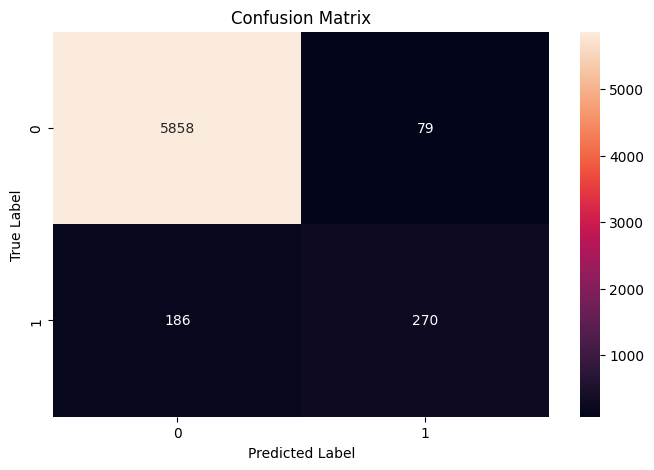

In [31]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [32]:
# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5937
           1       0.77      0.59      0.67       456

    accuracy                           0.96      6393
   macro avg       0.87      0.79      0.82      6393
weighted avg       0.96      0.96      0.96      6393

